In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## 1. Przygotowanie danych

In [3]:
path = "C:\\Users\\zibie\\berka\\"

# Wczytywanie plików
account_df = pd.read_csv("C:\\Users\\zibie\\berka\\account.csv", sep=';')
card_df = pd.read_csv("C:\\Users\\zibie\\berka\\card.csv", sep=';')
client_df = pd.read_csv("C:\\Users\\zibie\\berka\\client.csv", sep=';')
disp_df = pd.read_csv("C:\\Users\\zibie\\berka\\disp.csv", sep=';')
district_df = pd.read_csv("C:\\Users\\zibie\\berka\\district.csv", sep=';', dtype={0: int})
loan_df = pd.read_csv("C:\\Users\\zibie\\berka\\loan.csv", sep=';')
order_df = pd.read_csv("C:\\Users\\zibie\\berka\\order.csv", sep=';')
trans_df = pd.read_csv("C:\\Users\\zibie\\berka\\trans.csv", sep=';')  

# Nadanie nazw kolumn w tabeli district
district_df.columns = [
    "district_id", "district_name", "region", "no_inhabitants", "no_municipalities_0_499", 
    "no_municipalities_500_1999", "no_municipalities_2000_9999","no_municipalities_10000_plus",
    "no_cities", "ratio_urban_inhabitants", "avg_salary", "unemploy_rate_95", "unemploy_rate_96",        
    "no_entrepreneurs", "no_crimes_95", "no_crimes_96"               
]


# Zostawiamy konta właścicieli, bo tylko on może wziąć pożyczkę
owners_df = disp_df[disp_df['type'] == 'OWNER']


# Łączenie tabel
df_berka = (
    loan_df
    .merge(account_df, on='account_id', how='left')
    .merge(owners_df[['account_id', 'client_id']], on='account_id', how='left')
    .merge(client_df, on='client_id', how='left')
)

df_berka = df_berka.merge(
    district_df,
    left_on='district_id_y',
    right_on='district_id',
    how='left'
)
# Kolumna district_id_y pochodzi z tabeli district_df

C:\Users\zibie\AppData\Local\Temp\ipykernel_62492\1929399378.py:11: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_df = pd.read_csv("C:\\Users\\zibie\\berka\\trans.csv", sep=';')


In [4]:
# Obliczam wiek na podstawie danych z dokumentacji, które mówią o sposobie zapisu daty urodzenia dla kobiet ( YYMM+50DD) i mężczyzn (YYMMDD)
def extract_age(birth_num):
    year = int(str(birth_num)[:2])
    month = int(str(birth_num)[2:4])
    day = int(str(birth_num)[4:6])

    # Jeśli miesiąc > 50, to oznacza kobietę
    if month > 50:
        month -= 50

    # Dane są do 1998 roku, więc dodajemy 1900 do roku z danych
    year += 1900
    birth_date = datetime(year, month, day)

    today = datetime(1998, 12, 31) 
    age = (today - birth_date).days // 365
    return age

# Tworzymy kolumnę 'age'
df_berka['age'] = df_berka['birth_number'].apply(extract_age)

In [5]:
# Dodajemy nową kolumnę: 1 = niespłacona, 0 = spłacona
df_berka['loan_default'] = df_berka['status'].apply(lambda x: 1 if x in ['B', 'D'] else 0)

# Sprawdźmy ile jest pożyczek niespłaconych vs spłaconych
df_berka['loan_default'].value_counts()

loan_default
0    606
1     76
Name: count, dtype: int64

## 2. Eksploracyjna analiza danych (EDA)

In [7]:
df_berka.info()
df_berka.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_id                       682 non-null    int64  
 1   account_id                    682 non-null    int64  
 2   date_x                        682 non-null    int64  
 3   amount                        682 non-null    int64  
 4   duration                      682 non-null    int64  
 5   payments                      682 non-null    float64
 6   status                        682 non-null    object 
 7   district_id_x                 682 non-null    int64  
 8   frequency                     682 non-null    object 
 9   date_y                        682 non-null    int64  
 10  client_id                     682 non-null    int64  
 11  birth_number                  682 non-null    int64  
 12  district_id_y                 682 non-null    int64  
 13  distr

,loan_id,account_id,date_x,amount,duration,payments,district_id_x,date_y,client_id,birth_number,...,no_municipalities_2000_9999,no_municipalities_10000_plus,no_cities,ratio_urban_inhabitants,avg_salary,unemploy_rate_96,no_entrepreneurs,no_crimes_96,age,loan_default
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.00000,682.000000
mean,6172.466276,5824.162757,963027.910557,151410.175953,36.492669,4190.664223,37.489736,952313.549853,7120.573314,584201.796188,...,5.736070,1.724340,5.445748,67.863930,9469.230205,3.551598,120.585044,15651.299120,39.92522,0.111437
std,682.579279,3283.512681,14616.406049,113372.406310,17.075219,2215.830344,25.184326,14155.440348,4059.120567,127109.991957,...,4.611563,1.119954,2.855937,20.090892,1301.835849,2.140448,23.004614,30510.152293,12.69634,0.314903
min,4959.000000,2.000000,930705.000000,4980.000000,12.000000,304.000000,1.000000,930113.000000,2.000000,350129.000000,...,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000,18.00000,0.000000
25%,5577.500000,2967.000000,950704.500000,66732.000000,24.000000,2477.000000,13.000000,940523.000000,3582.250000,475770.750000,...,2.000000,1.000000,4.000000,52.000000,8544.000000,1.960000,106.000000,2265.250000,29.00000,0.000000
50%,6176.500000,5738.500000,970206.500000,116928.000000,36.000000,3934.000000,39.000000,960126.000000,6941.000000,581072.500000,...,5.000000,1.000000,6.000000,62.000000,8980.000000,3.490000,115.000000,3651.000000,40.00000,0.000000
75%,6752.500000,8686.000000,971212.500000,210654.000000,48.000000,5813.500000,60.000000,961017.500000,10711.000000,690356.500000,...,8.000000,2.000000,7.000000,85.500000,9897.000000,4.790000,132.000000,6295.000000,51.00000,0.000000
max,7308.000000,11362.000000,981208.000000,590820.000000,60.000000,9910.000000,77.000000,971222.000000,13971.000000,806207.000000,...,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000,63.00000,1.000000


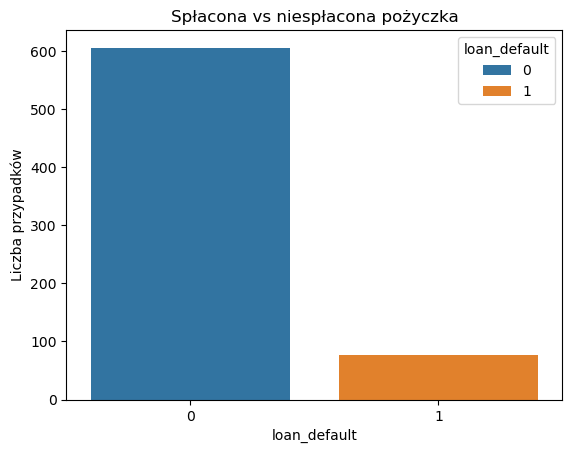

In [8]:
# Rozkład zmiennej docelowej 
sns.countplot(x='loan_default', data=df_berka, hue="loan_default")
plt.title("Spłacona vs niespłacona pożyczka")
plt.ylabel("Liczba przypadków")
plt.show()

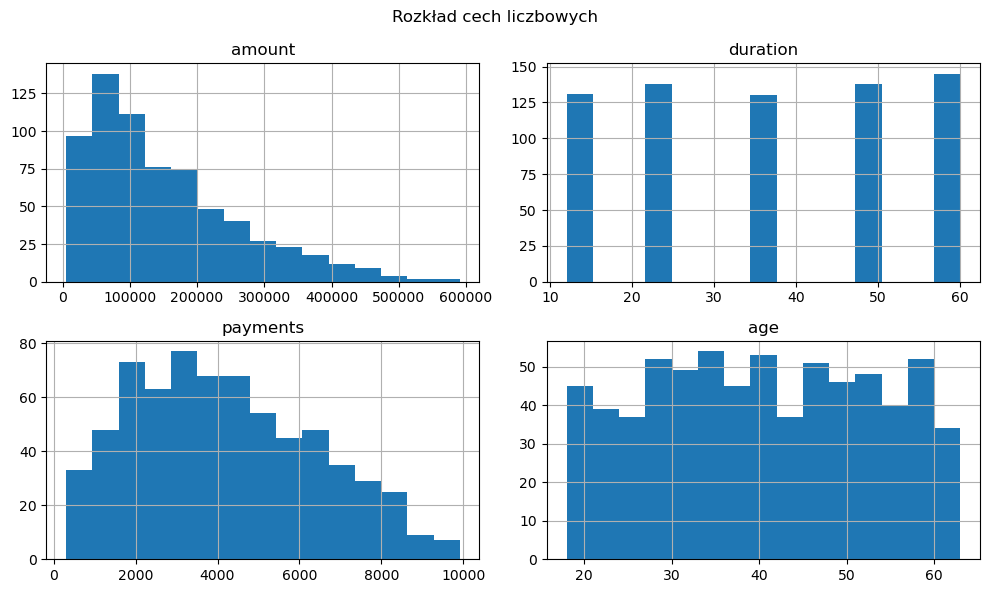

In [9]:
# Histogramy przedstawiające wysokość pożyczki, raty miesięcznej, czas trwania pożyczki oraz wiek
df_berka[['amount', 'duration', 'payments', 'age']].hist(bins=15, figsize=(10, 6))
plt.suptitle("Rozkład cech liczbowych")
plt.tight_layout()
plt.show()

C:\Users\zibie\AppData\Local\Temp\ipykernel_62492\3157911522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_default', y='amount', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})


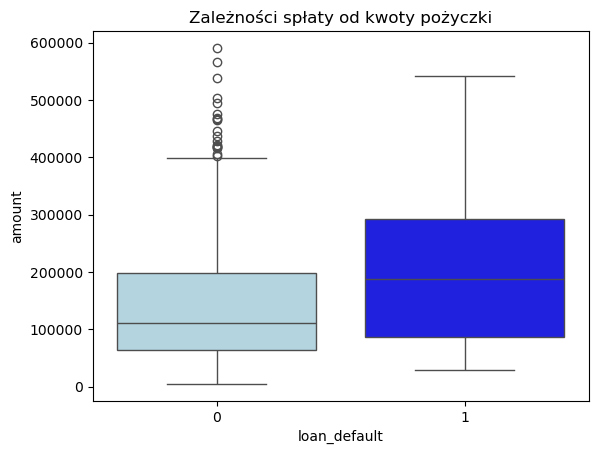

C:\Users\zibie\AppData\Local\Temp\ipykernel_62492\3157911522.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_default', y='age', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})


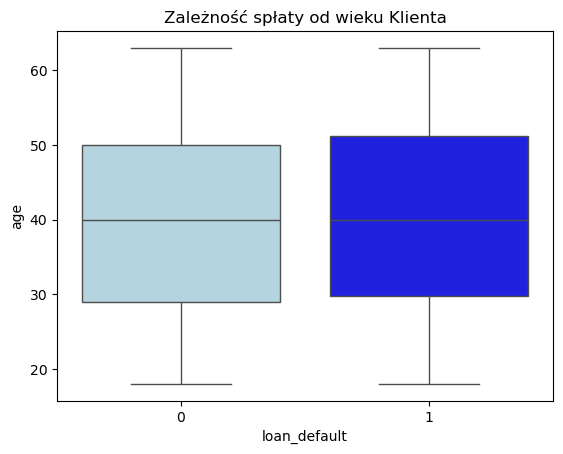

C:\Users\zibie\AppData\Local\Temp\ipykernel_62492\3157911522.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_default', y='avg_salary', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})


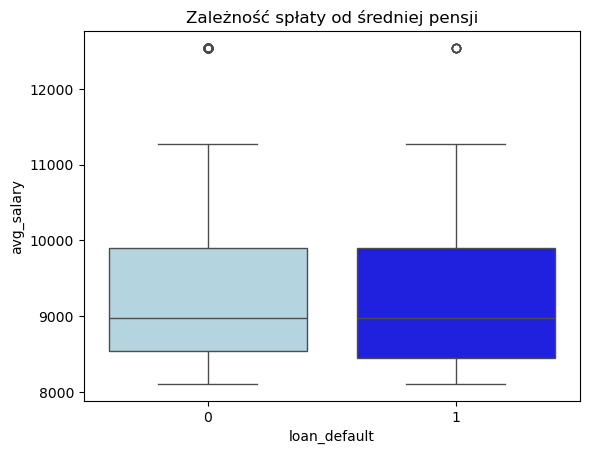

In [10]:
# Boxplot pokazujący zależność pomiędzy kwotą pożyczki, a wartościami 0 i 1 (spłacona, nie spłacona
sns.boxplot(x='loan_default', y='amount', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})
plt.title("Zależności spłaty od kwoty pożyczki")
plt.show()

sns.boxplot(x='loan_default', y='age', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})
plt.title("Zależność spłaty od wieku Klienta")
plt.show()

sns.boxplot(x='loan_default', y='avg_salary', data=df_berka, palette={'0': 'lightblue', '1': 'blue'})
plt.title("Zależność spłaty od średniej pensji")
plt.show()


Korelacje z loan_default:
loan_default                    1.000000
payments                        0.182440
amount                          0.167525
unemploy_rate_96                0.036183
district_id_y                   0.034961
district_id                     0.034961
duration                        0.025823
district_id_x                   0.020512
age                             0.011637
no_municipalities_0_499        -0.003040
ratio_urban_inhabitants        -0.004748
no_municipalities_500_1999     -0.005297
birth_number                   -0.011432
no_municipalities_10000_plus   -0.016862
no_inhabitants                 -0.030643
avg_salary                     -0.031355
no_crimes_96                   -0.033666
no_municipalities_2000_9999    -0.039377
no_entrepreneurs               -0.059283
no_cities                      -0.060212
loan_id                        -0.077255
account_id                     -0.078223
client_id                      -0.078783
date_y                         

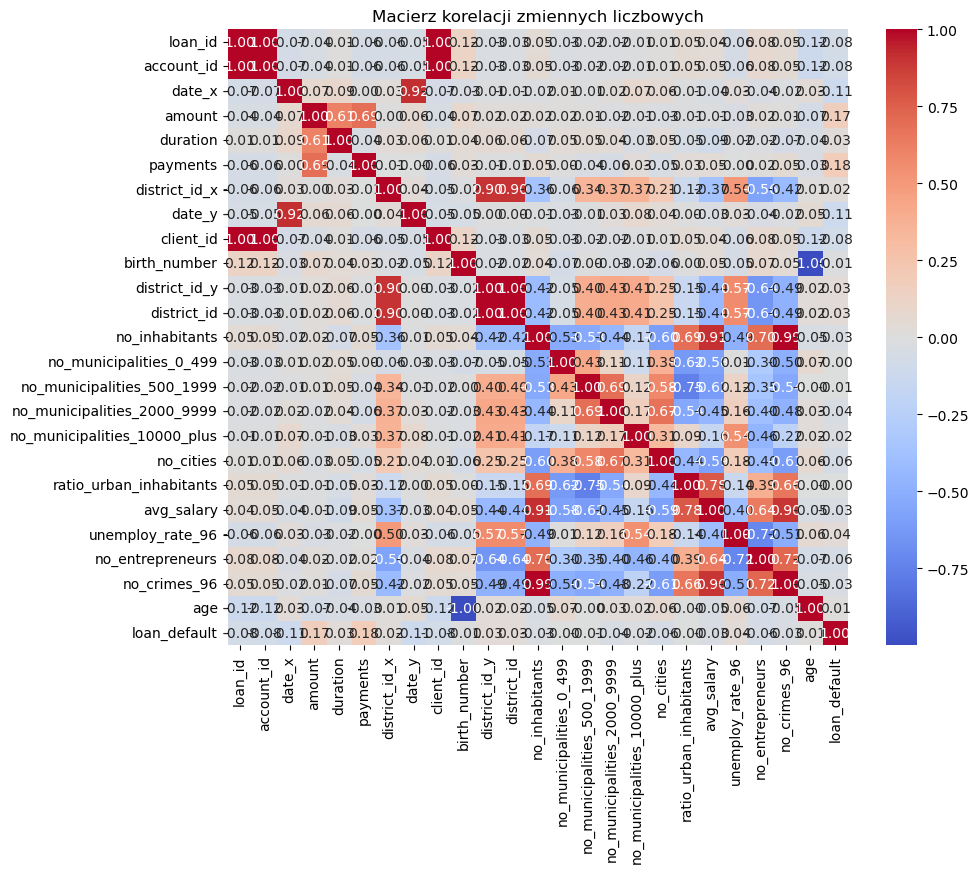

In [11]:
# Wybieramy tylko kolumny liczbowe 
numeric_df = df_berka.select_dtypes(include='number')

# Macierz korelacji 
correlation_matrix = numeric_df.corr()

print("Korelacje z loan_default:")
print(correlation_matrix['loan_default'].sort_values(ascending=False))


#Macierz korelacji zmiennych 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Macierz korelacji zmiennych liczbowych")
plt.show()

## 3. Budowa modelu predykcyjnego


 Wyniki regresji logistycznej:
Accuracy:  0.6788
Precision: 0.1915
Recall:    0.6000
F1 Score:  0.2903
ROC AUC:   0.6765


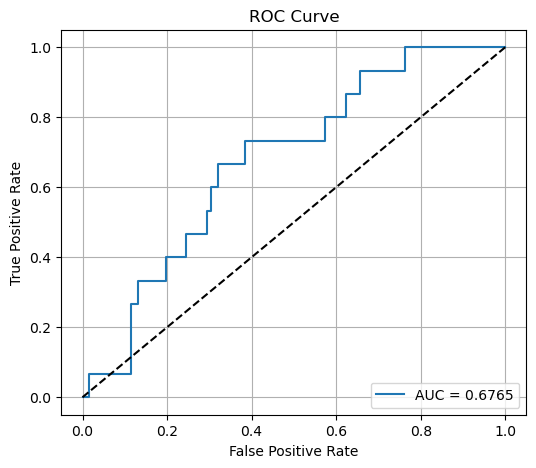

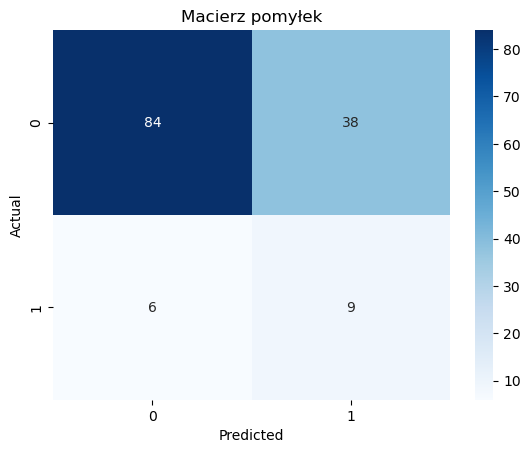

In [13]:
#Zakodowanie zmiennych kategorycznych (np. frequency)
X_berka = pd.get_dummies(
    df_berka[['amount', 'duration', 'age', 'frequency']],  # tylko bezpieczne kolumny
    drop_first=True
)

y_berka = df_berka['loan_default']

#Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(
    X_berka, y_berka, test_size=0.2, random_state=42, stratify=y_berka
)

# Standaryzacja 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresja logistyczna – trening modelu
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predykcja
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Metryki
print("\n Wyniki regresji logistycznej:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob):.4f}")

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



 Wyniki drzewa decyzyjnego:
Accuracy:  0.7518
Precision: 0.1724
Recall:    0.3333
F1 Score:  0.2273
ROC AUC:   0.5238


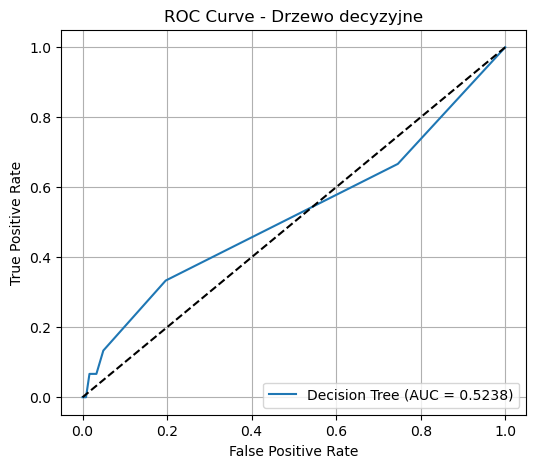

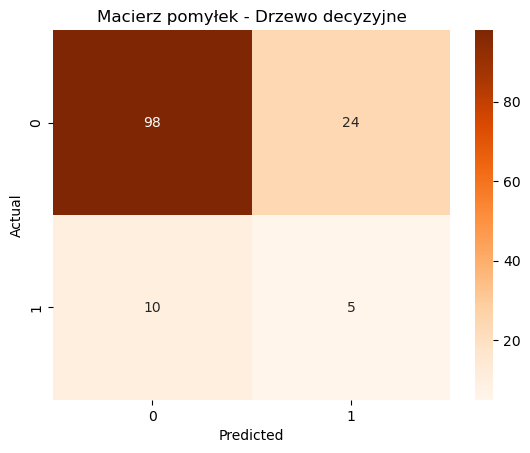

In [14]:
# Stworzenie i trenowanie modelu
tree_model = DecisionTreeClassifier(random_state=42, max_depth = 4, class_weight='balanced')
tree_model.fit(X_train_scaled, y_train)

# Predykcja
y_pred_tree = tree_model.predict(X_test_scaled)
y_prob_tree = tree_model.predict_proba(X_test_scaled)[:, 1]

# Metryki
print("\n Wyniki drzewa decyzyjnego:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tree):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tree):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_tree):.4f}")

# Krzywa ROC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
plt.figure(figsize=(6, 5))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_tree):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Drzewo decyzyjne')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Macierz pomyłek
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Oranges')
plt.title('Macierz pomyłek - Drzewo decyzyjne')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
coefficients_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)
print(coefficients_df)

                        feature  coefficient
0                        amount     0.681144
2                           age     0.098288
4      frequency_POPLATEK TYDNE     0.098175
3  frequency_POPLATEK PO OBRATU     0.073430
1                      duration    -0.253579


In [16]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance)

                        feature  importance
0                        amount    0.646842
2                           age    0.320294
1                      duration    0.032864
3  frequency_POPLATEK PO OBRATU    0.000000
4      frequency_POPLATEK TYDNE    0.000000


## 4. Analiza wyników i wnioski

Najważniejszą cechą wpływającą na niespłatę pożyczki była zmienna 'amount' (wysokość pożyczki). Widać to na podstawie coefficients z modelu regresji liniowej oraz feature importance drzewa decyzyjnego jak i na podstawie wykresu boxplot. Korelacje nie są zbyt mocne, ale można zauważyć, że im wyższa rata tym trudniejsza do spłaty.
Widać również, że cechy 'amount' i 'age' miały największy wpływ na decyzje drzewa decyzyjnego, co jest spójne z wynikami regresji logistycznej.

Regresja logistyczna lepiej wykrywa niespłacone pożyczki (Recall = 60%), czyli, że jeśli ktoś nie spłaci pożyczki, model ma 60% szans, że go poprawnie wykryje.

Dla ulepszenia modelu można użyć dodatkowych cech np. z regionu (district) takich jak dochody czy liczba miast.
W drzewach można dodatkowo ustawić dodatkowe parametry dotyczące liścia (min_samples_leaf). Wypróbować inne modele lepiej radzące sobie z niezbalansowanymi danymi np. XGBoost.

Model ten można wykorzytsac do oceny ryzyka (scoring) polegającego na tym czy dany Klient będzie w stanie spłacić pożyczkę. Może być on również wsparciem dla banku, jeżeli znajdzie się Klient z wysokim ryzkiem to zapropnować mu alternatywne rozwiązanie, czyli np. niższą kwotę pożyczki. 